In [427]:
from core.rabagliati_13_analysis import *
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('../data/rabagliati_2013_stimuli.csv')
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
tokenize_ctx = lambda t: tokenizer.tokenize(t)
df['tokenized_dis_ctx'] = df['dis_ctx'].apply(tokenize_ctx)
model = initialize_model()
df = df[~df['target'].isin(['moose', 'mousse'])] #BERT tokenization issues
bert_data = extract_embeddings_attns(df)

In [10]:
attn_ranks, results = disambig_ranks_attn(bert_data)

Text(0.5, 1, 'Normalized Ranks of Disambiguating Tokens')

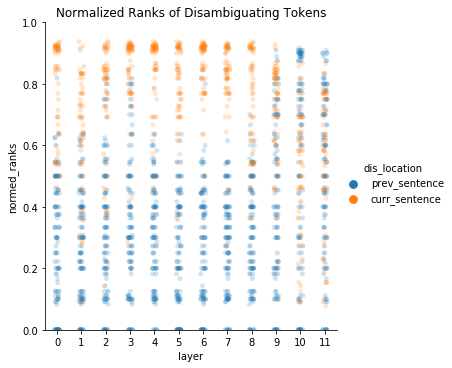

In [425]:
sns.catplot(x = 'layer', y = 'normed_ranks', hue = 'dis_location', data = attn_ranks, alpha = 0.2)
plt.ylim(0, 1)
plt.title("Normalized Ranks of Disambiguating Tokens")

Text(0.5, 1, 'Attention on Disambiguating Tokens')

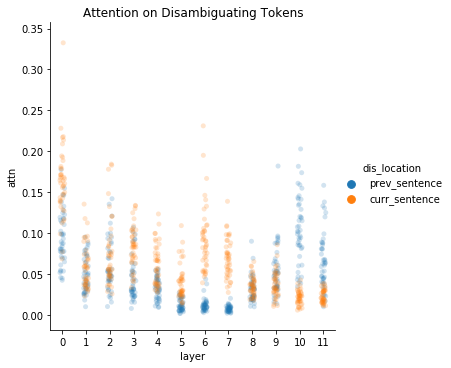

In [16]:
sns.catplot(x = 'layer', y = 'attn', hue = 'dis_location', data = results, alpha = 0.2)
plt.title("Attention on Disambiguating Tokens")

In [19]:
curr_prev_sent = total_attn_location(bert_data)

curr_prev_sent.groupby('sent_ctx').agg('mean').drop('layer', axis = 1)
#Average attention to sentences, Although the target sentence is attended to more, 
#the previous sentence has more attention if there is disambiguating information

,prior_attn,target_attn
sent_ctx,,
curr,0.056473,0.285316
prev,0.081344,0.193992


Text(0.5, 1, "Attention on First Sentence's Tokens")

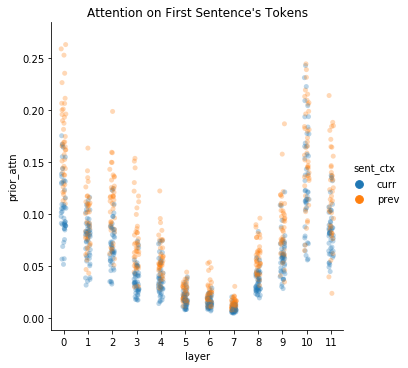

In [20]:
sns.catplot(x = 'layer', y = 'prior_attn', hue = 'sent_ctx', data = curr_prev_sent, alpha = 0.3)
plt.title("Attention on First Sentence's Tokens")

Text(0.5, 1, "Attention on Second Sentence's Tokens")

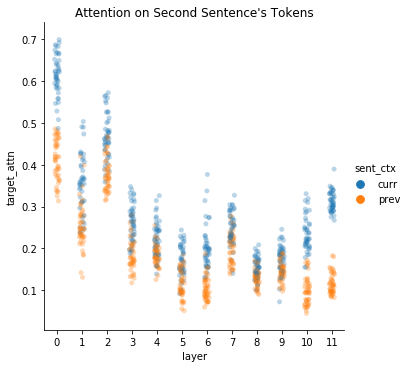

In [21]:
sns.catplot(x = 'layer', y = 'target_attn', hue = 'sent_ctx', data = curr_prev_sent, alpha = 0.3)
plt.title("Attention on Second Sentence's Tokens")

In [392]:
from matplotlib.backends.backend_pdf import PdfPages


Generating a PDF of attention graphs for each sentence

In [400]:
with PdfPages('Rabagliati_etal_2013_attentions.pdf') as pdf:

    for s in bert_data:
        fig = plt.figure(figsize = (30, 20))
        for i in range(1, 13):
            ax = fig.add_subplot(4, 3, i)
            sent_df = pd.DataFrame({"Tokens": s['tokenized_sents'], "Attention": s['attns'][i - 1]})
            ax = sns.barplot(x = sent_df.index, y = "Attention", data = sent_df)
            ax.set_xticklabels(s['tokenized_sents'])
            ax.set_xlabel("Token")
            ax.set_title("Layer " + str(i))
        plt.suptitle("Target: " + s['target_name'] + " Context: " + str(s['tokenized_dis']) + " Context Sentence: " + s['sent_ctx'],
                    fontsize = 18)
        pdf.savefig()
        plt.close()

Text(0.5, 1.0, 'Disambiguating Context in Previous Sentence')

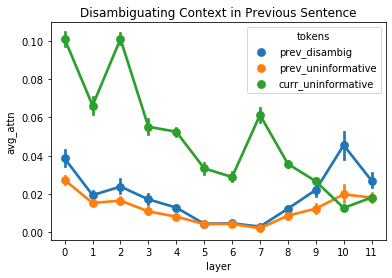

In [167]:
avg_attn_split = avg_attn(bert_data)
sns.pointplot(x = 'layer', y = 'avg_attn', data = avg_attn_split[avg_attn_split['ctx_sentence'] == 'prev'], hue = 'tokens', alpha = 0.1)
plt.title("Disambiguating Context in Previous Sentence")

Text(0.5, 1.0, 'Disambiguating Context in Same Sentence as Target')

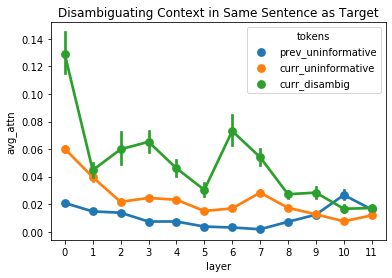

In [168]:
sns.pointplot(x = 'layer', y = 'avg_attn', data = avg_attn_split[avg_attn_split['ctx_sentence'] == 'curr'], hue = 'tokens', alpha = 0.1)
plt.title("Disambiguating Context in Same Sentence as Target")

In [288]:
def compare_sim(query, others, lst):
    """
    query- query embedding
    others- list of other embeddings
    lst- 
    """
    find_sim = lambda l, q: [t[1] for t in l if t[0] == q] 
    query_sim = find_sim(lst, query)
    return all([query_sim > find_sim(lst, o) for o in others])

Text(0.5, 1.0, 'Distribution of Cosine Similarities between Pairs of Different Word Senses')

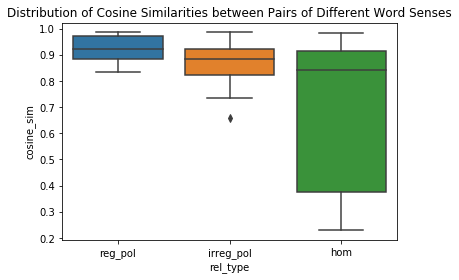

In [420]:
hp_data = hp_cs(bert_data)
sns.boxplot(hp_data['rel_type'], hp_data['cosine_sim'])
plt.title("Distribution of Cosine Similarities between Pairs of Different Word Senses")